# SSD: Single Shot MultiBox Detector

```
@misc{liu2015ssd,
    title={SSD: Single Shot MultiBox Detector},
    author={Wei Liu and Dragomir Anguelov and Dumitru Erhan and Christian Szegedy and Scott Reed and Cheng-Yang Fu and Alexander C. Berg},
    year={2015},
    eprint={1512.02325},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}
```

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

print('TensorFlow:', tf.__version__)

TensorFlow: 2.2.0-rc3


In [2]:
def imshow(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)


def draw_boxes_cv2(image, boxes, categories, show_labels=True):
    image = np.array(image, dtype=np.uint8)
    boxes = np.array(boxes, dtype=np.int32)
    categories = np.array(categories)
    for _box, _cls in zip(boxes, categories):
        if show_labels:
            text = _cls
            char_len = len(text) * 6
            text_orig = (_box[0] + 5, _box[1] - 6)
            text_bg_xy1 = (_box[0], _box[1] - 15)
            text_bg_xy2 = (_box[0] + char_len, _box[1])
            image = cv2.rectangle(image, text_bg_xy1, text_bg_xy2, [255, 252, 150],
                                  -1)
            image = cv2.putText(image,
                                text,
                                text_orig,
                                cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                .4, [0, 0, 0],
                                4,
                                lineType=cv2.LINE_AA)
            image = cv2.putText(image,
                                text,
                                text_orig,
                                cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                .4, [255, 255, 255],
                                1,
                                lineType=cv2.LINE_AA)
        image = cv2.rectangle(image, (_box[0], _box[1]), (_box[2], _box[3]),
                              [30, 15, 30], 1)
    return image

In [3]:
shapes_dataset_tfrecords_path = '../tutorials/data/shapes_dataset_tfrecords'
train_tfrecords_pattern = shapes_dataset_tfrecords_path + '/train*'
val_tfrecords_pattern = shapes_dataset_tfrecords_path + '/val*'

train_tfrecords = tf.data.Dataset.list_files(train_tfrecords_pattern)
val_tfrecords = tf.data.Dataset.list_files(val_tfrecords_pattern)

In [4]:
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'xmins': tf.io.VarLenFeature(tf.float32),
        'ymins': tf.io.VarLenFeature(tf.float32),
        'xmaxs': tf.io.VarLenFeature(tf.float32),
        'ymaxs': tf.io.VarLenFeature(tf.float32),
        'classes': tf.io.VarLenFeature(tf.int64),
    }

    parsed_example = tf.io.parse_single_example(example_proto,
                                                feature_description)
    image = tf.io.decode_image(parsed_example['image'], channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image.set_shape([None, None, 3])
    boxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs']),
    ],
                     axis=-1)
    classes = tf.sparse.to_dense(parsed_example['classes'])
    return image, boxes, classes

In [5]:
def random_flip_data(image, boxes):
    w = tf.cast(tf.shape(image)[1], dtype=tf.float32)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [w - boxes[:, 2], boxes[:, 1], w - boxes[:, 0], boxes[:, 3]],
            axis=-1)
    return image, boxes


def parse_and_create_label(example_proto):
    image, boxes, classes = parse_example(example_proto)
    image = (image - 127.5) / 127.5 # scale image so that pixel value are in [-1, 1]
    image, boxes = random_flip_data(image, boxes)
    label = create_label(boxes, classes)
    return image, label


def build_dataset(tfrecords, batch_size):
    dataset = tfrecords.interleave(
        tf.data.TFRecordDataset,
        cycle_length=8,
        block_length=32,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(512)
    dataset = dataset.map(parse_example,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
strategy = tf.distribute.MirroredStrategy()
print('\nNumber of Accelerators :', strategy.num_replicas_in_sync)

config = {
    'input_shape': [300, 300],
    'scales': [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05],
#     'scales': [0.1, 0.2, 0.38, 0.55, 0.72, 0.9, 1.08],
    'aspect_ratios': [[1 / 2, 1, 2], [1 / 2, 1 / 3, 1, 2, 3],
                     [1 / 2, 1 / 3, 1, 2, 3], [1 / 2, 1 / 3, 1, 2, 3],
                     [1 / 2, 1, 2], [1 / 2, 1, 2]],
    'feature_sizes': [38, 19, 10, 5, 3, 1],
    'loc_variance': [0.1, 0.1, 0.2, 0.2],
    'clip_default_boxes': False,
    'num_classes': 2,
    'match_iou_threshold': 0.5,
    'nms_iou_threshold': 0.5,
    'score_threshold': 0.45,
    'batch_size': 4 * strategy.num_replicas_in_sync
}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

Number of Accelerators : 1


In [7]:
def change_box_format(boxes, return_format='xywh'):
    boxes = tf.cast(boxes, dtype=tf.float32)
    if return_format == 'xywh':
        return tf.stack([(boxes[..., 2] + boxes[..., 0]) / 2.0,
                         (boxes[..., 3] + boxes[..., 1]) / 2.0, boxes[..., 2] -
                         boxes[..., 0], boxes[..., 3] - boxes[..., 1]],
                        axis=-1)
    elif return_format == 'x1y1x2y2':
        return tf.stack([
            boxes[..., 0] - boxes[..., 2] / 2.0, boxes[..., 1] -
            boxes[..., 3] / 2.0, boxes[..., 0] + boxes[..., 2] / 2.0,
            boxes[..., 1] + boxes[..., 3] / 2.0
        ],
                        axis=-1)

In [8]:
# smin = 20
# smax = 90
# m = 5
# scales = [0.1]
# for k in range(1, m+2):
#     sl = smin + (smax - smin)//(m - 1) * (k - 1)
#     scales.append(sl/100)
# assert scales == [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]

In [9]:
class DefaultBoxes:

    def __init__(self, config):
        self._input_shape = config['input_shape']
        self._scales = config['scales']
        self._feature_sizes = config['feature_sizes']
        self._strides = [np.ceil(300 / x) for x in config['feature_sizes']]
        self._aspect_ratios = config['aspect_ratios']
        self.clip_default_boxes = config['clip_default_boxes']
        self._default_boxes = []
        self._build_default_boxes()

    def _build_meshgrid(self, feature_size):
        meshgrid = tf.stack(tf.meshgrid(tf.range(feature_size),
                                        tf.range(feature_size)),
                            axis=-1)
        return tf.cast(meshgrid, dtype=tf.float32)

    def _get_dims(self, scale, ratio):
        h = self._input_shape[0] * scale / np.sqrt(ratio)
        w = self._input_shape[1] * scale * np.sqrt(ratio)
        wh = tf.constant([w, h], dtype=tf.float32, shape=[1, 1, 2])
        return wh

    def _build_default_boxes(self):
        default_boxes = []
        for i in range(len(self._feature_sizes)):
            feature_size = self._feature_sizes[i]
            aspect_ratios = self._aspect_ratios[i]
            sl = self._scales[i]
            sl_next = self._scales[i + 1]

            meshgrid = self._build_meshgrid(feature_size)
            centers = (meshgrid + 0.5) * self._strides[i]
            
            default_box = []
            for ratio in aspect_ratios:
                wh = self._get_dims(sl, ratio)
                wh = tf.tile(wh, multiples=[feature_size, feature_size, 1])
                box = tf.concat([centers, wh], axis=-1)
                box = tf.expand_dims(box, axis=2)
                default_box.append(box)

            extra_wh = tf.constant([
                self._input_shape[0] * np.sqrt(sl * sl_next),
                self._input_shape[1] * np.sqrt(sl * sl_next)
            ],
                                   dtype=tf.float32,
                                   shape=[1, 1, 2])
            extra_wh = tf.tile(extra_wh,
                               multiples=[feature_size, feature_size, 1])
            extra_box = tf.concat([centers, extra_wh], axis=-1)
            extra_box = tf.expand_dims(extra_box, axis=2)
            default_box.append(extra_box)
            
            default_box = tf.concat(default_box, axis=2)
            default_box = tf.reshape(default_box, shape=[-1, 4])
            default_boxes.append(default_box)
        self._default_boxes = tf.concat(default_boxes, axis=0)
        
        if self.clip_default_boxes:
            '''
            convert to x1y1x2y2
            clip (coord, 0, 300)
            convert back to xywh
            '''
            pass

    @property
    def boxes(self):
        return self._default_boxes
    
class BoxMatcher:
    def __init__(self, iou_threshold=0.5):
        self._iou_threshold = iou_threshold
        
    def _compute_iou(self, boxes1, boxes2):
        boxes1 = tf.cast(boxes1, dtype=tf.float32)
        boxes2 = tf.cast(boxes2, dtype=tf.float32)

        boxes1_t = change_box_format(boxes1, return_format='x1y1x2y2')
        boxes2_t = change_box_format(boxes2, return_format='x1y1x2y2')

        lu = tf.maximum(boxes1_t[:, None, :2], boxes2_t[:, :2])
        rd = tf.minimum(boxes1_t[:, None, 2:], boxes2_t[:, 2:])

        intersection = tf.maximum(0.0, rd - lu)
        inter_square = intersection[:, :, 0] * intersection[:, :, 1]

        square1 = boxes1[:, 2] * boxes1[:, 3]
        square2 = boxes2[:, 2] * boxes2[:, 3]

        union_square = tf.maximum(square1[:, None] + square2 - inter_square, 1e-10)
        return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)
        
    def __call__(self, default_boxes, gt_boxes):
        iou_matrix = self._compute_iou(default_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.cast(tf.greater_equal(max_iou, self._iou_threshold), dtype=tf.float32)
        return matched_gt_idx, positive_mask


class LabelEncoder:

    def __init__(self, config):
        self._default_boxes = DefaultBoxes(config).boxes
        self._loc_variance = tf.constant(config['loc_variance'], dtype=tf.float32)
        self._num_classes = config['num_classes']
        self._box_matcher = BoxMatcher(config['match_iou_threshold'])

    def _compute_loc_target(self, matched_gt_boxes):
        loc_target = tf.concat([
            (matched_gt_boxes[:, :2] - self._default_boxes[:, :2]) / self._default_boxes[:, 2:],
            tf.math.log(matched_gt_boxes[:, 2:] / self._default_boxes[:, 2:])
        ], axis=-1)
        loc_target = loc_target / self._loc_variance
        return loc_target
        
    def _encode_sample(self, gt_boxes, cls_ids):
        cls_ids = tf.cast(cls_ids + 1, dtype=tf.float32)  # add background class with cls_id = 0
        
        matched_gt_idx, positive_mask = self._box_matcher(self._default_boxes, gt_boxes)
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)

        loc_target = self._compute_loc_target(matched_gt_boxes)
        cls_target = tf.cast(matched_gt_cls_ids * positive_mask, dtype=tf.int32)
        cls_target = tf.one_hot(cls_target, depth=self._num_classes+1, dtype=tf.float32)
        return loc_target, cls_target
    
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(self, config, **kwargs):
        super(DecodePredictions, self).__init__(**kwargs)
        self._default_boxes = DefaultBoxes(config).boxes
        self._loc_variance = config['loc_variance']
        self._nms_iou_threshold = config['nms_iou_threshold']
        self._nms_score_threshold = config['score_threshold']

    def _decode_loc_predictions(self, loc_predictions):
        boxes = loc_predictions * self._loc_variance
        boxes = tf.concat([
            boxes[:, :2] * self._default_boxes[:, 2:] + self._default_boxes[:, :2],
            tf.math.exp(boxes[:, 2:]) * self._default_boxes[:, 2:]
        ],
                          axis=-1)
        boxes_transformed = change_box_format(boxes, return_format='x1y1x2y2')
        return boxes_transformed

    def _decode_cls_predictions(self, cls_predictions):
        cls_ids = tf.argmax(cls_predictions, axis=-1)
        cls_ids = cls_ids - 1  # background is encoded cls_id 0 
        cls_scores = tf.reduce_max(cls_predictions, axis=-1)
        
        return cls_ids, cls_scores

    def _filter_background_predictions(self, boxes, cls_ids, cls_scores):
        foreground_idx = tf.where(cls_ids != 0)[:, 0]
        
        filtered_boxes = tf.gather(boxes, foreground_idx)
        filtered_cls_ids = tf.gather(cls_ids, foreground_idx)
        filtered_cls_scores = tf.gather(cls_scores, foreground_idx)
        return filtered_boxes, filtered_cls_ids, filtered_cls_scores

    def call(self, predictions):
        predictions = predictions[0]

        loc_predictions = predictions[:, :4]
        cls_predictions = predictions[:, 4:]

        boxes = self._decode_loc_predictions(loc_predictions)
        cls_ids, cls_scores = self._decode_cls_predictions(cls_predictions)
        
        boxes, cls_ids, cls_scores = self._filter_background_predictions(boxes,
                                                                         cls_ids,
                                                                         cls_scores)
        nms_idx = tf.image.non_max_suppression(boxes,
                                               cls_scores,
                                               max_output_size=100,
                                               iou_threshold=self._nms_iou_threshold,
                                               score_threshold=self._nms_score_threshold)
        
        decoded_boxes = tf.gather(boxes, nms_idx)
        decoded_cls_ids = tf.gather(cls_ids, nms_idx)
        decoded_cls_scores = tf.gather(cls_scores, nms_idx)
        
        return decoded_boxes, decoded_cls_ids, decoded_cls_scores

### Check Encoding

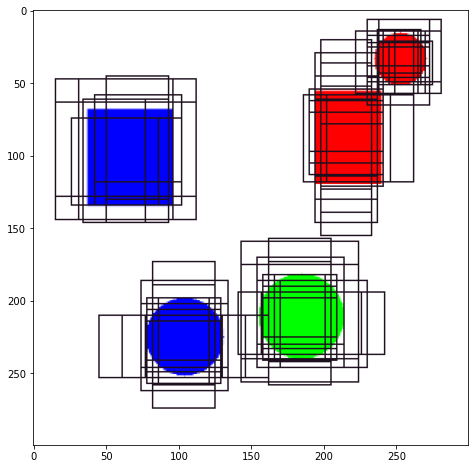

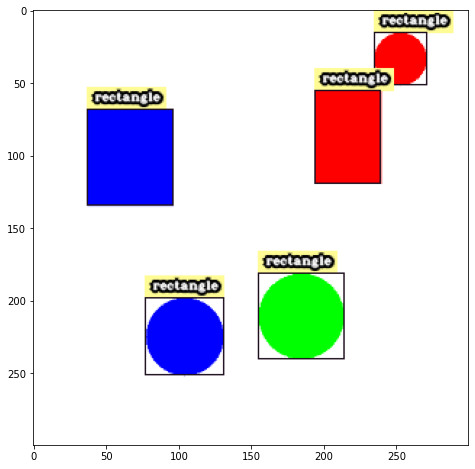

In [43]:
dataset = build_dataset(train_tfrecords, 1)
label_encoder = LabelEncoder(config)
for image, boxes, classes in dataset.take(1):
    image = tf.image.resize(image, [300, 300])
    boxes = boxes*300/448
    boxes_xywh = change_box_format(boxes, return_format='xywh')
    label = label_encoder._encode_sample(boxes_xywh, classes)
    label = tf.concat(label, axis=-1)[None, ...]
    decoded_boxes, decoded_cls_ids, _ = DecodePredictions(config)(label)    
    
    positive_mask = tf.cast(tf.argmax(label[0, :, 4:], axis=-1)!=0, dtype=tf.float32)
    matched_default_boxes = tf.gather(label_encoder._default_boxes, tf.where(positive_mask!=0)[:, 0])
    matched_default_boxes_xywh = change_box_format(matched_default_boxes, return_format='x1y1x2y2')

    imshow(draw_boxes_cv2(image, matched_default_boxes_xywh, range(len(matched_default_boxes)), show_labels=False))
    imshow(draw_boxes_cv2(image, decoded_boxes, ['circle' if x == 0 else 'rectangle' for x in decoded_cls_ids], show_labels=True))

In [6]:
def conv_layer(tensor,
               filters,
               kernel_size,
               stride,
               padding='same',
               w_init=tf.initializers.glorot_normal):
    return tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=kernel_size,
                                  strides=stride,
                                  padding=padding,
                                  kernel_initializer=w_init)(tensor)


def build_model(num_classes=2):
    default_boxes = [4, 6, 6, 6, 4, 4]
    base_model = tf.keras.applications.ResNet50(input_shape=[300, 300, 3],
                                                include_top=False,
                                                weights='imagenet')
    feature_maps = [
        base_model.get_layer(layer).output for layer in
        ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    ]
    x = base_model.output
    x = conv_layer(x, 256, 1, 1)
    x = conv_layer(x, 256, 3, 2)
    feature_maps.append(x)
    x = conv_layer(x, 128, 1, 1, padding='valid')
    x = conv_layer(x, 256, 3, 1, padding='valid')
    feature_maps.append(x)
    x = conv_layer(x, 128, 1, 1, padding='valid')
    x = conv_layer(x, 256, 3, 1, padding='valid')
    feature_maps.append(x)

    outputs = []
    for i, feature_map in enumerate(feature_maps):
        filters = default_boxes[i] * (4 + num_classes + 1)
        y = conv_layer(feature_map, filters, 3, 1)
        y = tf.keras.layers.Reshape([-1, 4 + num_classes + 1])(y)
        outputs.append(y)
    prediction = tf.keras.layers.Concatenate(axis=1)(outputs)
    model = tf.keras.Model(inputs=[base_model.input],
                           outputs=[prediction],
                           name='SSD')
    return model

## Implementing Loss functions

In [ ]:
class SSDLocLoss(tf.losses.Loss):
    pass


class SSDClsLoss(tf.losses.Loss):
    pass

In [7]:
model = build_model(num_classes=2)
default_boxes = DefaultBoxes(**config)

In [8]:
model(tf.random.normal([1, 300, 300, 3]))

<tf.Tensor: shape=(1, 8732, 6), dtype=float32, numpy=
array([[[ 0.20844515, -1.3278862 ,  0.83444494, -0.65102065,
         -2.9813375 , -1.2271886 ],
        [ 0.08294801, -0.8132075 ,  1.6412677 , -0.8853096 ,
          1.2581884 ,  0.5719473 ],
        [ 1.4424982 , -0.58966994, -1.5887465 , -2.7098904 ,
         -0.600199  ,  0.05868107],
        ...,
        [-0.436692  , -0.65218467, -0.69499856, -0.76058984,
          0.23132701,  0.2934894 ],
        [-0.894344  , -0.15233374,  0.394225  ,  0.47983184,
          0.2652601 ,  0.7091137 ],
        [-0.23398116, -1.0034909 ,  0.75078976, -0.23263337,
         -0.5205121 , -0.6275463 ]]], dtype=float32)>

In [9]:
default_boxes.boxes

<tf.Tensor: shape=(8732, 4), dtype=float32, numpy=
array([[  4.      ,   4.      ,  21.213203,  42.426407],
       [  4.      ,   4.      ,  30.      ,  30.      ],
       [  4.      ,   4.      ,  42.426407,  21.213203],
       ...,
       [150.      , 150.      , 264.      , 264.      ],
       [150.      , 150.      , 373.3524  , 186.6762  ],
       [150.      , 150.      , 288.37476 , 288.37476 ]], dtype=float32)>